<a href="https://colab.research.google.com/github/danielzoch/QPEHashing/blob/main/QPEHashing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit_ibm_provider
!pip install pylatexenc
!pip install qiskit
!pip install qiskit-ibmq-provider

In [8]:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy, IBMQ
import numpy as np

# Function to create controlled addition gate
def cadd(a, N):
    """Controlled addition gate."""
    U = QuantumCircuit(3, name=f'cadd_{a}')
    for _ in range(a):
        U.x(0)
        U.mcx([0, 1], 2)
        U.x(0)
    return U

# Function to create inverse Quantum Fourier Transform gate
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

def qpe_circuit(a, exponent, N, precision):
    # Quantum registers
    n_count = len(bin(N)[2:])  # Number of bits to represent N in binary
    qr = QuantumCircuit(n_count + precision + 1, precision)

    # Apply Hadamard gate to counting qubits
    qr.h(range(n_count + precision))

    # Prepare counting qubits in state |1>
    qr.x(n_count + precision)

    # Controlled-U operations
    for q in range(precision):
        cu_gate = cadd(2**(n_count - 1), N)
        qr.append(cu_gate, [i for i in range(3)])  # Use only the first 3 qubits

    # Inverse QFT
    qr.append(qft_dagger(n_count + precision),
             [i for i in range(n_count + precision)])  # Do inverse QFT

    # Measure counting qubits
    qr.measure(range(n_count, n_count + precision), range(precision))

    # Run on IBM Quantum device
    backend = get_backend()
    result = run_on_ibmq(qr, backend)

    # Extract counts of the first register
    first_register_counts = {key[:n_count]: val for key, val in result.items()}

    return first_register_counts, result

# Function to get the least busy IBM Quantum device
def get_backend():
    IBMQ.save_account("ENTER_API_KEY_HERE", overwrite=True)
    # Load IBM Quantum account
    IBMQ.load_account()

    # Get the least busy IBM Quantum device
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3
                                                  and not x.configuration().simulator
                                                  and x.status().operational==True))
    return backend

# Function to run the circuit on an IBM Quantum device
def run_on_ibmq(qc, backend):
    """Function to run the circuit on an IBM Quantum device."""
    t_qpe = transpile(qc, backend, optimization_level=3)
    qpe_circuit_instance = assemble(t_qpe)
    result = backend.run(qpe_circuit_instance, shots=1).result()
    counts = result.get_counts()
    return counts

a = 2
exponent = 3
N = 15
precision = 6  # Precision for Quantum Phase Estimation

# Run the quantum circuit
results = {}
first_register_counts, all_counts = qpe_circuit(a, exponent, N, precision)

<ipython-input-8-4f234e5f8467>:79: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  result = backend.run(qpe_circuit_instance, shots=1).result()


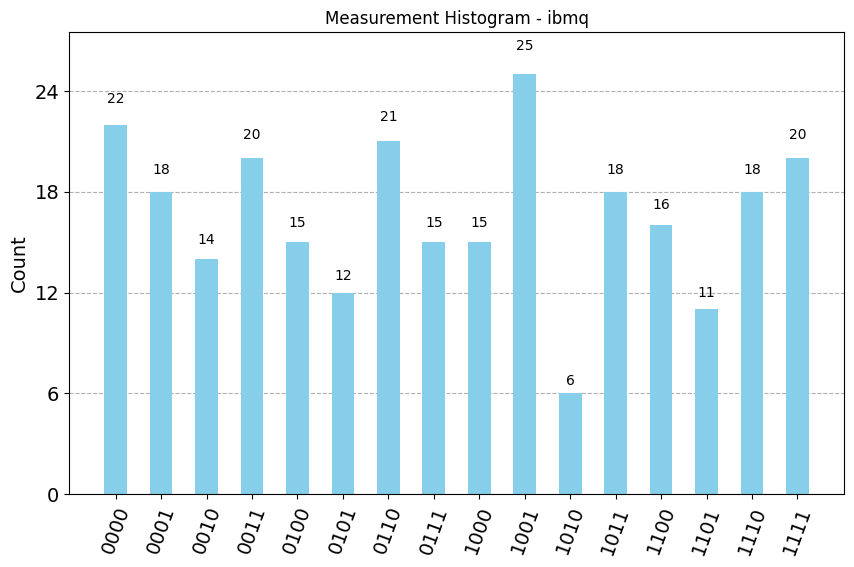

In [13]:
# Plot histogram for the first register counts
plot_histogram(first_register_counts, title='Measurement Histogram - ibmq', bar_labels=True, figsize=(10, 6), color='skyblue')

In [14]:
# Print out the results of the first register
sorted_dict = dict(sorted(first_register_counts.items()))
print("Results of the First Register:")
for key, value in sorted_dict.items():
    print(f"{key}: {value}")

Results of the First Register:
0000: 22
0001: 18
0010: 14
0011: 20
0100: 15
0101: 12
0110: 21
0111: 15
1000: 15
1001: 25
1010: 6
1011: 18
1100: 16
1101: 11
1110: 18
1111: 20


In [17]:
import hashlib

def quantum_hash(qpe_results):
    # Combine quantum results into a classical hash
    hash_value = 0

    for result in qpe_results:
        # Assuming qpe_results are 0 or 1, XOR them into the hash_value
        hash_value ^= result

    return hash_value

def sha2_hash(message):
    # Use SHA-256 from Python's hashlib library
    sha2 = hashlib.sha256()
    sha2.update(message.encode())
    return sha2.hexdigest()

def hybrid_hash(qpe_results, message):
    # Combine quantum and classical hashes
    quantum_part = quantum_hash(qpe_results)
    classical_part = sha2_hash(message)

    # XOR the quantum and classical hashes
    hybrid_result = quantum_part ^ int(classical_part, 16)

    # Convert the result to hexadecimal for representation
    hex_result = hex(hybrid_result)[2:]

    return hex_result

# Example QPE results (replace this with your actual QPE results)
qpe_results = [int(bit) for bit in list(first_register_counts.keys())[0]]

# Example message to hash
message = "Hello, Quantum World!"

# Generate hybrid hash
hybrid_result = hybrid_hash(qpe_results, message)

# Output the hybrid hash result
print("Hybrid Hash Value: " + hybrid_result)



Hybrid Hash Value: e4c4d673739173999072899c2aeb8063c98af6ad86259779d33bdf8db9914e3e
